In [15]:
# -*- coding: utf-8 -*-
"""
Predict Q6 Satisfaction using Main Questions and Sub-Questions
Robust version: dynamically detects column names to avoid KeyError
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [16]:
# -----------------------------
# 1. Load the Data
# -----------------------------
# Important: Load with no header splitting issues
df = pd.read_csv('student_survey_data.csv', header=0)  # Use first row as header

print(f"Loaded data with {len(df)} rows and {len(df.columns)} columns")
print("\nFirst few columns:")
print(df.columns.tolist()[:10])

# Check for any problematic characters in column names (like commas inside names)
print("\nChecking for commas in column names...")
for col in df.columns:
    if ',' in col:
        print(f"Column contains comma: {col}")

# Clean column names: remove or replace problematic characters
df.columns = df.columns.str.replace(',', '', regex=False)  # Remove commas
df.columns = df.columns.str.strip()  # Remove whitespace

print("\n✅ Cleaned column names (first 10):")
print(df.columns.tolist()[:10])

# Drop rows with missing Q6 (target)
df.dropna(subset=['Q6_How_Satisfied_You_are_with_your_Student_Life'], inplace=True)
df.rename(columns={'Q6_How_Satisfied_You_are_with_your_Student_Life': 'Q6'}, inplace=True)

# Ensure Department and Gender are categorical
df['Department'] = df['Department'].astype('category')
df['Gender'] = df['Gender'].astype('category')

Loaded data with 1565 rows and 72 columns

First few columns:
['response_id', 'Career', 'Citizenship', 'Nationality', 'Year_since_Matriculation', 'Year_of_Study', 'Primary_Programme', 'Gender', 'Department', 'Housing_Type']

Checking for commas in column names...

✅ Cleaned column names (first 10):
['response_id', 'Career', 'Citizenship', 'Nationality', 'Year_since_Matriculation', 'Year_of_Study', 'Primary_Programme', 'Gender', 'Department', 'Housing_Type']


In [17]:
# -----------------------------
# 2. Helper: Find Sub-Question Columns by Prefix
# -----------------------------
def get_sub_cols(prefix):
    """Dynamically find all columns that start with given prefix"""
    return [col for col in df.columns if col.startswith(prefix)]

In [18]:
# -----------------------------
# 3. Feature Engineering
# -----------------------------

# --- Q1: Volunteering ---
q1_main = 'Q1_How_many_events_have_you_Volunteered_in'
q1_sub_prefix = 'Q1_Volunteered_For_'
q1_sub_cols = get_sub_cols(q1_sub_prefix)

if q1_sub_cols:
    print(f"Found {len(q1_sub_cols)} Q1 sub-questions")
    df['Q1_freq'] = df[q1_main]
    df['Q1_diversity'] = df[q1_sub_cols].sum(axis=1)
    df['Q1_diversity_norm'] = df['Q1_diversity'] / len(q1_sub_cols)
    # Example flags (use only if columns exist)
    if 'Q1_Volunteered_For_Animal_welfare' in q1_sub_cols:
        df['Q1_vol_animal'] = df['Q1_Volunteered_For_Animal_welfare']
    if 'Q1_Volunteered_For_Environmental_sustainability' in q1_sub_cols:
        df['Q1_vol_env'] = df['Q1_Volunteered_For_Environmental_sustainability']
else:
    print("No Q1 sub-questions found!")
    df['Q1_freq'] = df[q1_main]
    df['Q1_diversity_norm'] = 0

# --- Q2: Participation ---
q2_main = 'Q2_How_many_events_have_you_Participated_in'
q2_sub_prefix = 'Q2_Participated_in_'
q2_sub_cols = get_sub_cols(q2_sub_prefix)

if q2_sub_cols:
    print(f"Found {len(q2_sub_cols)} Q2 sub-questions")
    df['Q2_freq'] = df[q2_main]
    df['Q2_diversity'] = df[q2_sub_cols].sum(axis=1)
    df['Q2_diversity_norm'] = df['Q2_diversity'] / len(q2_sub_cols)
    # Try to extract key flags safely
    for col in ['Clubs', 'Societies_and_Interest_Groups', 'HallsJCRCs_and_or_Residential_College_CSCs', 'University_organised_events']:
        full_col = f'Q2_Participated_in_{col}'
        if full_col in df.columns:
            df[f'Q2_{col.split("_")[0].lower()}'] = df[full_col]
else:
    print("No Q2 sub-questions found!")
    df['Q2_freq'] = df[q2_main]
    df['Q2_diversity_norm'] = 0

# --- Q3: Interests ---
q3_main = 'Q3_How_many_activities_are_you_Interested_in'
q3_sub_prefix = 'Q3_Interested_in_'
q3_sub_cols = get_sub_cols(q3_sub_prefix)

if q3_sub_cols:
    print(f"Found {len(q3_sub_cols)} Q3 sub-questions")
    df['Q3_intensity'] = df[q3_main]
    df['Q3_diversity'] = df[q3_sub_cols].sum(axis=1)
    df['Q3_diversity_norm'] = df['Q3_diversity'] / len(q3_sub_cols)
else:
    print("No Q3 sub-questions found!")
    df['Q3_intensity'] = df[q3_main]
    df['Q3_diversity_norm'] = 0

# --- Q4: Passion ---
q4_main = 'Q4_How_many_activities_are_you_Passionate_about'
q4_sub_prefix = 'Q4_Passionate_about_'
q4_sub_cols = get_sub_cols(q4_sub_prefix)

if q4_sub_cols:
    print(f"Found {len(q4_sub_cols)} Q4 sub-questions")
    df['Q4_intensity'] = df[q4_main]
    df['Q4_diversity'] = df[q4_sub_cols].sum(axis=1)
    df['Q4_diversity_norm'] = df['Q4_diversity'] / len(q4_sub_cols)
else:
    print("No Q4 sub-questions found!")
    df['Q4_intensity'] = df[q4_main]
    df['Q4_diversity_norm'] = 0

# --- Q5: Stress ---
q5_main = 'Q5_What_are_your_levels_of_stress'
q5_sub_prefix = 'Q5_Stressed_about_'
q5_stress_cols = get_sub_cols(q5_sub_prefix)

if q5_stress_cols:
    print(f"Found {len(q5_stress_cols)} Q5 stress domains")
    df['Q5_level'] = df[q5_main]
    df['Q5_domains'] = df[q5_stress_cols].sum(axis=1)
    # Add key stress flags
    for domain in ['Academic_issues', 'Financial_issues', 'Friendships', 'Romantic_relationships']:
        col = f'Q5_Stressed_about_{domain}'
        if col in df.columns:
            df[f'Q5_{domain.split("_")[0].lower()}'] = df[col]
else:
    print("No Q5 sub-questions found!")
    df['Q5_level'] = df[q5_main]
    df['Q5_domains'] = 0

# --- Q7 and Q8 ---
if 'Q7_How_much_effort_do_you_make_to_interact_with_others' in df.columns:
    df['Q7_effort'] = df['Q7_How_much_effort_do_you_make_to_interact_with_others']
if 'Q8_About_How_events_are_you_aware_about' in df.columns:
    df['Q8_awareness'] = df['Q8_About_How_events_are_you_aware_about']

Found 12 Q1 sub-questions
Found 5 Q2 sub-questions
Found 8 Q3 sub-questions
Found 13 Q4 sub-questions
Found 10 Q5 stress domains


In [19]:
# -----------------------------
# 4. Scale Numeric Predictors
# -----------------------------
scaler = StandardScaler()

numeric_cols = [
    'Q1_freq', 'Q2_freq', 'Q3_intensity', 'Q4_intensity', 'Q5_level',
    'Q7_effort', 'Q8_awareness', 'Q1_diversity_norm', 'Q2_diversity_norm',
    'Q3_diversity_norm', 'Q4_diversity_norm', 'Q5_domains'
]

for col in numeric_cols:
    if col in df.columns and df[col].nunique() > 1:  # Only scale if exists and varies
        df[f'{col}_scaled'] = scaler.fit_transform(df[[col]])
    else:
        df[f'{col}_scaled'] = 0  # Default if missing

In [20]:
# -----------------------------
# 5. Build Model Formula
# -----------------------------
# Start with core predictors
predictors = [
    'Q1_freq_scaled', 'Q2_freq_scaled', 'Q3_intensity_scaled', 'Q4_intensity_scaled',
    'Q5_level_scaled', 'Q7_effort_scaled', 'Q8_awareness_scaled',
    'Q1_diversity_norm_scaled', 'Q2_diversity_norm_scaled', 'Q3_diversity_norm_scaled',
    'Q4_diversity_norm_scaled', 'Q5_domains_scaled'
]

# Add any binary flags that exist
optional_flags = [
    'Q1_vol_animal', 'Q1_vol_env',
    'Q2_Clubs', 'Q2_Societies', 'Q2_Halls', 'Q2_University',
    'Q5_Academic', 'Q5_Financial', 'Q5_Friendships', 'Q5_Romantic'
]

for flag in optional_flags:
    if flag in df.columns:
        predictors.append(flag)

# Add demographics
predictors += ['C(Gender)', 'C(Year_of_Study)']

# Add interaction
formula_str = 'Q6 ~ ' + ' + '.join(predictors)
formula_str += ' + Q1_freq_scaled:Q5_level_scaled'  # Interaction

print(f"\n📊 Final Model Formula:")
print(formula_str)



📊 Final Model Formula:
Q6 ~ Q1_freq_scaled + Q2_freq_scaled + Q3_intensity_scaled + Q4_intensity_scaled + Q5_level_scaled + Q7_effort_scaled + Q8_awareness_scaled + Q1_diversity_norm_scaled + Q2_diversity_norm_scaled + Q3_diversity_norm_scaled + Q4_diversity_norm_scaled + Q5_domains_scaled + Q1_vol_animal + Q1_vol_env + C(Gender) + C(Year_of_Study) + Q1_freq_scaled:Q5_level_scaled


In [21]:
# -----------------------------
# 6. Fit HLM (Random Intercept by Department)
# -----------------------------
print("\n📈 Fitting HLM with random intercept by Department...")

try:
    model = smf.mixedlm(
        formula=formula_str,
        data=df,
        groups=df["Department"]
    )
    result = model.fit(method='lbfgs', maxiter=1000)
    print(result.summary())
except Exception as e:
    print(f"HLM fitting failed: {e}")
    print("Trying simplified model...")
    simple_formula = "Q6 ~ Q1_freq_scaled + Q5_level_scaled + C(Gender) + C(Department)"
    model_simple = smf.mixedlm(simple_formula, df, groups=df["Department"])
    result_simple = model_simple.fit(method='lbfgs', maxiter=1000)
    print(result_simple.summary())



📈 Fitting HLM with random intercept by Department...
                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Q6        
No. Observations:       1565          Method:                   REML      
No. Groups:             10            Scale:                    0.2834    
Min. group size:        135           Log-Likelihood:           -1309.3702
Max. group size:        170           Converged:                Yes       
Mean group size:        156.5                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       3.847    0.176  21.817 0.000  3.502  4.193
C(Gender)[T.Male]              -0.024    0.027  -0.880 0.379 -0.077  0.029
C(Year_of_Study)[T.2]           0.112    0.039   2.902 0.004  0.0

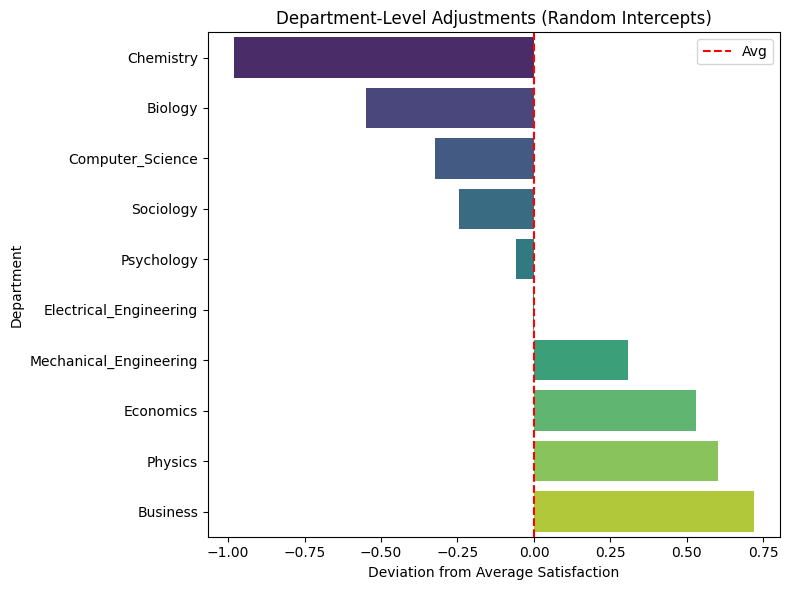

In [22]:
# -----------------------------
# 7. Visualize Department Effects
# -----------------------------
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    if 'result' in locals():
        random_effects = result.random_effects
        dept_effects = pd.DataFrame([
            {'Department': dept, 'Effect': effect[0]} for dept, effect in random_effects.items()
        ]).sort_values('Effect')

        plt.figure(figsize=(8, 6))
        sns.barplot(data=dept_effects, x='Effect', y='Department', palette='viridis')
        plt.axvline(0, color='red', linestyle='--', label='Avg')
        plt.title('Department-Level Adjustments (Random Intercepts)')
        plt.xlabel('Deviation from Average Satisfaction')
        plt.legend()
        plt.tight_layout()
        plt.show()
except ImportError:
    print("Matplotlib/seaborn not available for plotting.")

In [23]:
# -----------------------------
# 8. Final Check: Show First Rows of Engineered Data
# -----------------------------
print("First 5 rows of key engineered features:")
print(df[[c for c in df.columns if 'diversity' in c or 'freq' in c or 'scaled' in c or 'Q6' == c] + ['Department', 'Gender']].head())

First 5 rows of key engineered features:
   Q6  Q1_freq  Q1_diversity  Q1_diversity_norm  Q2_freq  Q2_diversity  \
0   3        5             0           0.000000        2             2   
1   3        2             1           0.083333        9             1   
2   4        9             4           0.333333        4             1   
3   5       10             3           0.250000        0             0   
4   3        7             1           0.083333        0             2   

   Q2_diversity_norm  Q3_diversity  Q3_diversity_norm  Q4_diversity  ...  \
0                0.4             2              0.250             4  ...   
1                0.2             0              0.000             1  ...   
2                0.2             1              0.125             6  ...   
3                0.0             0              0.000             3  ...   
4                0.4             3              0.375             5  ...   

   Q5_level_scaled  Q7_effort_scaled  Q8_awareness_scaled

In [24]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# ------------------------------------
# Step 1: Define Features
# ------------------------------------
main_features = [
    'Q1_How_many_events_have_you_Volunteered_in',
    'Q2_How_many_events_have_you_Participated_in',
    'Q3_How_many_activities_are_you_Interested_in',
    'Q4_How_many_activities_are_you_Passionate_about',
    'Q5_What_are_your_levels_of_stress',
    'Q7_How_much_effort_do_you_make_to_interact_with_others',
    'Q8_About_How_events_are_you_aware_about'
]

# Dynamically collect all binary sub-questions
sub_features = [
    col for col in df.columns
    if col.startswith(('Q1_Volunteered_For_', 'Q2_Participated_in_', 'Q3_Interested_in_', 'Q4_Passionate_about_', 'Q5_Stressed_about_'))
]

# Combine all predictors
features = main_features + sub_features

# ------------------------------------
# Step 2: Encode Categorical Variables
# ------------------------------------
categorical_vars = ['Gender', 'Year_of_Study']
df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# Add one-hot encoded categorical columns to features list
encoded_cat_cols = [col for col in df_encoded.columns if any(c in col for c in categorical_vars)]
features += encoded_cat_cols

# ------------------------------------
# Step 3: Prepare Feature Matrix
# ------------------------------------
X = df_encoded[features].copy()
y = df_encoded['Q6']  # Assumes Q6 is already renamed

# Handle missing values
X.fillna(0, inplace=True)

# ------------------------------------
# Step 4: Fit Pipeline with LassoCV
# ------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=5000))
])

pipeline.fit(X, y)

# ------------------------------------
# Step 5: Show Important Coefficients
# ------------------------------------
coefs = pd.Series(pipeline.named_steps['lasso'].coef_, index=X.columns)
important = coefs[coefs.abs() > 0].sort_values(key=abs, ascending=False)

print("Top Predictors Selected by Lasso:")
print(important.head(15))

# ------------------------------------
# Step 6: Model Performance (Cross-Validated)
# ------------------------------------
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Set:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


Top Predictors Selected by Lasso:
Q1_How_many_events_have_you_Volunteered_in         0.532852
Q5_What_are_your_levels_of_stress                 -0.324537
Year_of_Study_2                                    0.036507
Q4_How_many_activities_are_you_Passionate_about    0.023621
Q2_Participated_in_Clubs                           0.020524
Q5_Stressed_about_Family_issues                   -0.014471
Q4_Passionate_about_Diversity_Inclusion           -0.011468
Q4_Passionate_about_Animal_welfare                 0.010574
Gender_Male                                       -0.008679
Q3_Interested_in_Research_and_independent_study    0.007262
Q1_Volunteered_For_Animal_welfare                 -0.004529
Q1_Volunteered_For_Health_Well_being               0.003431
Q2_Participated_in_Halls                          -0.003054
Q1_Volunteered_For_Community_building              0.001415
dtype: float64
Model Performance on Test Set:
R²: 0.418
RMSE: 0.796
